# Install or Import Relevant Packages

In [ ]:
# uncomment if you have don't have torch or torchvision installed in
# !pip install torch torchvision


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Select device
Select device to train the network. "cuda:0" means the first GPU device. If no GPU device is found, the device will default to CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Load in the MNIST dataset
For repeadable experiments the random seed must be set so that the same psuedo-random numbers are used in the wieght initialization and the dataset split. This is done by the call: `torch.manual_seed()` and `np.random.seed()`.

The MNIST dataset is loaded using torchvision by the call `torchvision.datasets.MNIST()`. The dataset is split into two disjoint sets for training and validation using the call `torch.utils.data.dataset.random_split()`, another common dataset splitter is scikit learns `sklearn.model_selection.train_test_split()`. In this instance, we are using 30% of the data for validation, 70% for training. The testing data is loaded by setting `torchvision.datasets.MNIST(...train=False...)`.

There is also an option to transform the data, this generally improves generalizability of the network. This is done by defining the transforms in the `transforms.Compose()` call.

In [3]:
# Set seed for repeatability
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

# Define the validation ratio to be used
valid_ratio = 0.3

# Transform data to improve generalizability
transform = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Load in the datasets
train_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Number of images to use for training
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
# Number of images to use for validation
nb_valid =  int(valid_ratio * len(train_valid_dataset))
# Randomly split into training and validation data
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

# Put into dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=500, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 168808640.44it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39991975.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42975867.00it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2516914.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Visualize the MNIST dataset
Define a helper function to visualize the MNIST images.

The first four images in the train loader are retrieved by the `iter(trainloader)` and `next(data_iter)` calls.

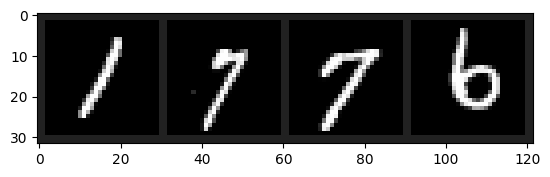

Ground Truth:     1     7     7     6


In [5]:
def imshow(img):
  img = (img - torch.min(img))/torch.max(img - torch.min(img))
  np_img = img.numpy()      # convert to numpy
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()                # needed to print the plot

# Get random training images
data_iter = iter(trainloader)
imgs, labels = next(data_iter)

# Show images (that are currently tensors)
imshow(torchvision.utils.make_grid(imgs[:4,]))
print('Ground Truth:', ' '.join('%5s' % labels[j].cpu().detach().numpy() for j in range(4)))

# Define Network
This will be a fully connected net, there are many different ways to define a network. Some people use Module (base class for NNs), others use the Sequential container. Either way, you need to specify two main things:
1. The network structure
2. The forward function - this passes the data into the network.

The MNIST data is 28x28 pixel images. The fully connected layer is specified as nn.Linear. The network structure typically consists of 3 main components:
- Input layer: where the data first goes into the network. The size of this layer must be the same size as the data you are trying to feed into it.
- Hidden Layers: there can be however many neurons in these layers as desired, additionally there can be however mady of these hidden layers you want. The input to the hidded layers must be the same size as the output of the previous layer.
- Output layer: This will be where the classification occurs, in classification problems, the number of nuerons in the output layer must be equal to the number of classes. Additionally, the input size of this layer must be the same size as the output of the previous layer.

The forward function is how the data passes through the network. This is where activation functions go.

Link that may be useful in network definition, this describes all the containers, layers, activation functions, and loss functions:
https://pytorch.org/docs/stable/nn.html


#  <font color='red'> TO DO - YOUR CODE HERE </font>
Create a fully connected linear neural network using the following parameters:
- Input layer with input size being the number of pixels in the MNIST image
- Output layer with output size being the number of unique classes (digits)
- Connect layers with ReLU activation function

This network has a hidden layer of 64 neurons.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 64)     # Put input size here
        self.fc2 = nn.Linear(64, 10)    # Put output size here

    def forward(self, x):
        # Put relu activation for self.fc1 here
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Compile and print the network structure

In [10]:
net = Net()
# This is especially helpful for debugging purposes if you are getting errors
#  in your network definition.
print('Number of parameters =', sum([p.numel() for p in net.parameters()]))

# Send network to device
net.to(device)

Number of parameters = 50890


Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

# Loss and optimizer definition
Define the loss to be minimized during training and the optimizer for the network. For classification, a typical loss function is cross entropy. Typical optimizers are Adam and SGD.

Within the optimizer call, you must specifiy what network you are going to be using it on, this is the net.parameters() variable. Additionally, specify an initial learning rate, this is the lr variable.

Links for more information:
- General information: https://pytorch.org/docs/stable/optim.html
- Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
- SGD: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD


#  <font color='red'> TO DO - YOUR CODE HERE </font>
Use cross entropy as your loss function (loss_criterion)
and define SGD as your optimization function (optimizer)

In [38]:
learning_rate = 0.01

# Use cross entropy as your loss function
loss_criterion = torch.nn.CrossEntropyLoss()
# Use SGD as your optimizer, specify the network parameters and learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Specify path to save the model to


In [39]:
PATH = './MNIST_FC_net.pth'


# Define Training Function

#  <font color='red'> TO DO - YOUR CODE HERE </font>
Within the training loop, code the four steps to complete the automatic differentiation:
- Forward pass
- Calculate loss
- Send the loss backward thru the network
- Use the optimizer to calculate the gradients and update weights

In [40]:
def train_network(model, train_loader, val_loader, optimizer, criterion, max_epochs):
    min_valid_loss = np.inf
    val_loss = []
    val_acc = []
    t_loss = []
    for epoch in range(max_epochs):
        train_loss = 0.0
        # Training loop
        for inputs, labels in train_loader:
            # Transfer Data to device
            inputs = inputs.view(-1, 28*28)   # Flatten for linear layer
            inputs, labels = inputs.to(device), labels.to(device)
            # Clear the gradients
            optimizer.zero_grad()

            # TO DO: CODE HERE
            pred = model.forward(inputs) # Forward Pass
            loss = loss_criterion(pred, labels) # Find the Loss
            loss.backward() # Send Loss backward
            optimizer.step() # Update Weights

            # Calculate Loss
            train_loss += loss.item()

        t_loss.append(train_loss/len(train_loader))     # epoch training loss

        valid_loss = 0.0
        epoch_total = 0
        epoch_correct = 0
        # Validation loop - the network weights should not be adjusted
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Transfer Data to device
                inputs = inputs.view(-1, 28*28)   # Flatten for linear layer
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward Pass
                outputs = model(inputs)
                # Find the Loss
                loss = criterion(outputs, labels)
                # Calculate Loss
                valid_loss += loss.item()
                # Calculate Accuracy
                _, predicted = torch.max(outputs.data, 1)
                epoch_total += labels.size(0)
                epoch_correct += (predicted == labels).sum().item()

        val_loss.append(valid_loss/len(validloader))
        val_acc.append(epoch_correct/epoch_total)
        print(f'Epoch {epoch+1}, Training Loss: {train_loss / len(trainloader):.5f}, Validation Loss: {valid_loss / len(validloader):.5f}')

        if min_valid_loss > valid_loss:
          # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
          # Saving State Dict
            torch.save(model.state_dict(), PATH)

    return val_loss, val_acc

# Define Testing Function

In [41]:
def test_network(model, test_loader):
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(-1,28*28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100*correct/total
    return accuracy



# Perform network training
This is where the training loop is called, you must give the function:
- nework/model
- traning dataloader
- validation dataloader
- optimizer (defined above)
- criterion / loss function (defined above)
- maximum number of epochs to train the model for


In [42]:
val_loss, val_acc = train_network(
                                    net, trainloader, validloader,
                                    optimizer=optimizer, criterion=loss_criterion,
                                    max_epochs=10
                                )



Epoch 1, Training Loss: 1.64804, Validation Loss: 1.11695
Epoch 2, Training Loss: 0.86890, Validation Loss: 0.71992
Epoch 3, Training Loss: 0.62233, Validation Loss: 0.56955
Epoch 4, Training Loss: 0.51656, Validation Loss: 0.49398
Epoch 5, Training Loss: 0.45883, Validation Loss: 0.44923
Epoch 6, Training Loss: 0.42253, Validation Loss: 0.41923
Epoch 7, Training Loss: 0.39734, Validation Loss: 0.39698
Epoch 8, Training Loss: 0.37870, Validation Loss: 0.38049
Epoch 9, Training Loss: 0.36403, Validation Loss: 0.36731
Epoch 10, Training Loss: 0.35223, Validation Loss: 0.35646


# Plot Validation Metrics

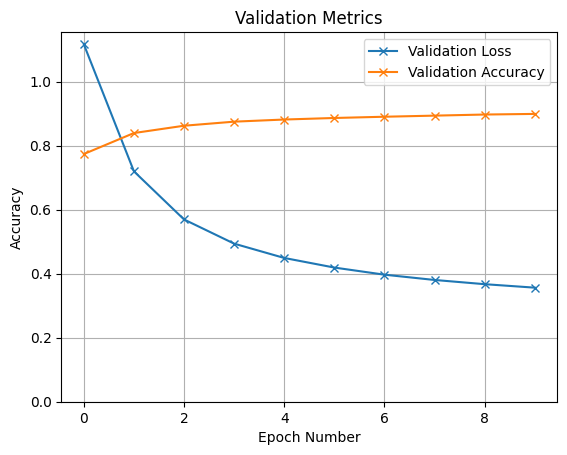

In [43]:
fig = plt.figure()
plt.plot(val_loss, '-x', label='Validation Loss')
plt.plot(val_acc, '-x', label='Validation Accuracy')

plt.xlabel('Epoch Number')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Accuracy')
plt.title('Validation Metrics')
plt.grid()
plt.legend()
plt.show()



# Evaluate the trained network
This loads in the saved network parameters, sets the model into evaluation mode so that the gradients will not be calculated, and calls the testing network funciton.

In [44]:
# Load saved net
net.load_state_dict(torch.load(PATH))



<All keys matched successfully>

Testing Accuracy =  90.78


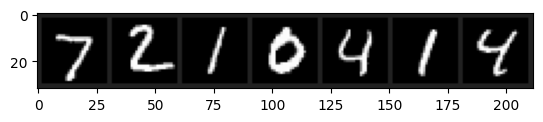

Truth:	     7     2     1     0     4     1     4
Predict:     7     2     1     0     4     1     4


In [45]:
net.eval()    # Put the model into evaluation mode

acc = test_network(net, testloader)
print('Testing Accuracy = ', acc)

# Get random testing images
data_iter = iter(testloader)
imgs, labels = next(data_iter)
labels = labels.cpu().detach().numpy()

# Show images (that are currently tensors) and their predictions
n_images = 7
imshow(torchvision.utils.make_grid(imgs[:n_images,]))
print('Truth:\t', ' '.join('%5s' % labels[j] for j in range(n_images)))

with torch.no_grad():
    outputs = net(imgs[:n_images,].view(-1, 28*28).to(device))
    _, predicted = torch.max(outputs, 1)

predicted = predicted.cpu().detach().numpy()
print('Predict:', ' '.join('%5s' % predicted[j] for j in range(n_images)))

